In [2]:
%pip install langchain-google-genai

  Using cached langchain_google_genai-2.1.8-py3-none-any.whl.metadata (7.0 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
  Using cached langchain_core-0.3.72-py3-none-any.whl.metadata (5.8 kB)
  Using cached google_api_core-2.25.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached google_auth-2.40.3-py2.py3-none-any.whl.metadata (6.2 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached grpcio_status-1.74.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached protobuf-6.31.1-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached grpcio-1.74.0-cp312-cp312-win_amd64.w

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogen-core 0.6.1 requires protobuf~=5.29.3, but you have protobuf 6.31.1 which is incompatible.

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import os # for dotenv
import random # for randomly chosing the element
import gradio as gr # for chat interface
from dotenv import load_dotenv # fot dotenv
from pydantic import BaseModel # for determining argument and return type
from langgraph.graph import StateGraph, START, END # for building graph
from langgraph.graph.message import add_messages # reducer passed to state
from langchain_openai import ChatOpenAI # llm
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated # Annotation
from IPython.display import Image, display # displaying compiled graph
from langchain_core.messages import SystemMessage

In [2]:
load_dotenv(override=True)

True

In [5]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [6]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [7]:
graph_builder = StateGraph(State)

In [8]:
def our_first_node(old_state: State) -> State:
    response = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": response}]
    new_state = State(messages = messages)
    return new_state

In [9]:
graph_builder.add_node("first_node", our_first_node)
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

In [10]:
graph = graph_builder.compile()

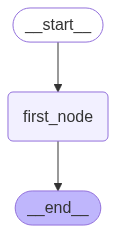

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
def chat(user_input: str, history):
    messages = [{"role": "user", "content": user_input}]
    state = State(messages = messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [3]:
# Step 1: Defining state
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [4]:
graph_builder = StateGraph(State)

In [5]:
google_api_key = os.getenv('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [6]:
def chatbot_node(old_state: State) -> State:

    # passing messages in the format of llm response in the case of already using llm(gemini) gives error as there is no need to do so, as it is already handled by the llm, instead pass a 
    # Don't wrap AIMessage into a dict — just pass it directly as State(messages=[reply])
    # reply = llm.invoke(old_state.messages)
    # messages = [{"role": "assistant", "content": reply}]
    # new_state = State(messages=messages)
    reply = llm.invoke(old_state.messages)  # returns AIMessage
    new_state = State(messages=[reply])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [7]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

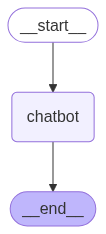

In [8]:
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
def chat(user_input: str, history):
    state = State(messages = [{"role": "user", "content": user_input}])
    result = graph.invoke(state)
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='46e7d0ec-e695-41f2-9673-0ad29d6d1eb8'), AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--be73d56a-d50a-4278-bf58-955cfcdb891f-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='6fc9d8af-3dfe-44bb-8cd6-824b7bc1b8d7'), AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6b476737-7b61-43f1-b888-95877c567075-0', usage_metadata={'input_tokens': 1, 'o

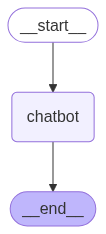

* Running on local URL:  http://127.0.0.1:7873
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='1+2', additional_kwargs={}, response_metadata={}, id='9315749b-8bba-45ea-a1fd-3b084bf43acf'), AIMessage(content='1 + 2 = 3', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--38b6bc50-3c8c-423d-b3bc-4bb6a41826a9-0', usage_metadata={'input_tokens': 3, 'output_tokens': 8, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='1+2', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='1ee8a3fe-c9d1-4c09-8a4e-abf7bbf6c035'), AIMessage(content='1 + 2 = 3', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='6676cbf2-bbd1-4b6d-8cb5-1500673cb842'), HumanMessage(content='1+2', additional_kwargs={}, response_metadata={}, id='2737d7fc-7710-45c7-9cd8-b489dd0657fb'), AIMessage(content='3', additional_kwargs={}, response

In [26]:
from typing import Annotated
import os
from pydantic import BaseModel
from IPython.display import display, Image
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import gradio as gr
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv(override=True)
google_api_key = os.getenv('GOOGLE_API_KEY')

class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

def chatbot_node(old_state: State) -> State:
    # Invoke the LLM with the current messages
    # sends [HumanMessage(content="hi")] to the Gemini model.
    reply = llm.invoke(old_state.messages)  # Returns AIMessage
    
    # Append the reply to the existing messages using add_messages
    new_messages = old_state.messages + [reply]
    
    # here, add_messages ensures the HumanMessage and AIMessage are appended correctly.
    # this returns dictionary containing "messages" array
    new_state = State(messages=new_messages)
    return new_state

# Add the node and edges
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Define the chat function to handle Gradio input and history
def chat(user_input: str, history: list):
    # Use history directly; if empty, include the user_input
    messages = history or [{"role": "user", "content": user_input}]
    
    # If history is not empty, ensure the last user input isn't duplicated
    if history and history[-1]["role"] == "user" and history[-1]["content"] == user_input:
        messages = history
    else:
        messages = history + [{"role": "user", "content": user_input}]
    
    # Create the State object
    # the State class processes the message using add_messages
    # add_message converts the dictionary messages to a HumanMessage object
    state = State(messages=messages)

    # Invoke the graph
    # this graph will run the chatbot_node
    result = graph.invoke(state)
    print(result)
    # Return the latest assistant message for Gradio
    return result['messages'][-1].content

# Launch the Gradio interface
gr.ChatInterface(chat, type="messages").launch()




#--------------------------
# add_message is invoked when State object is created (State(messages=messages)) or updated (new_state = State(messages=new_messages))
# add_message functionality:
#    converts the input dictionaries to HumanMessage objects
#    appends the AIMessage objects from LLM to the messages list
#    it ensures the list maintains the order, (user → assistant → user → assistant)
#--------------------------

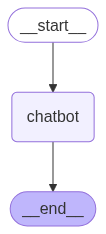

* Running on local URL:  http://127.0.0.1:7875
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='1', additional_kwargs={}, response_metadata={}, id='aa5749f4-f495-4664-99c8-b7c4f9b306d2'), AIMessage(content="Okay. Is there anything specific you'd like me to do with the number 1? For example:\n\n*   **Calculate something with it?** (e.g., 1 + 1, 1 * 5)\n*   **Tell you a fact about it?**\n*   **Use it in a sentence?**\n*   **Include it in a list?**\n\nLet me know how I can help!", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--6f366b57-b7a8-4f96-96b7-e578c5997d9b-0', usage_metadata={'input_tokens': 1, 'output_tokens': 93, 'total_tokens': 94, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='1', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='1ef8d739-7fc1-4dc8-8727-9d3fa68c5258'), AIMessage(content="Okay. Is there anything specific you'd li

In [28]:
from typing import Annotated
import os
from pydantic import BaseModel
from IPython.display import display, Image
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import gradio as gr
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv(override=True)
google_api_key = os.getenv('GOOGLE_API_KEY')

class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

def chatbot_node(old_state: State) -> State:
    # Invoke the LLM with the current messages
    # sends [HumanMessage(content="hi")] to the Gemini model.
    reply = llm.invoke(old_state.messages)  # Returns AIMessage
    
    # Append the reply to the existing messages using add_messages
    new_messages = old_state.messages + [reply]
    
    # here, add_messages ensures the HumanMessage and AIMessage are appended correctly.
    # this returns dictionary containing "messages" array
    new_state = State(messages=new_messages)
    return new_state

# Add the node and edges
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Define the chat function to handle Gradio input and history
def chat(user_input: str, history: list):
    # Use history directly; if empty, include the user_input
    messages = history or [{"role": "user", "content": user_input}]
    
    # If history is not empty, ensure the last user input isn't duplicated
    if history and history[-1]["role"] == "user" and history[-1]["content"] == user_input:
        messages = history
    else:
        messages = history + [{"role": "user", "content": user_input}]
    messages = messages[-4:]
    # Create the State object
    # the State class processes the message using add_messages
    # add_message converts the dictionary messages to a HumanMessage object
    state = State(messages=messages)

    # Invoke the graph
    # this graph will run the chatbot_node
    result = graph.invoke(state)
    print(result)
    # Return the latest assistant message for Gradio
    return result['messages'][-1].content

# Launch the Gradio interface
gr.ChatInterface(chat, type="messages").launch()




#--------------------------
# add_message is invoked when State object is created (State(messages=messages)) or updated (new_state = State(messages=new_messages))
# add_message functionality:
#    converts the input dictionaries to HumanMessage objects
#    appends the AIMessage objects from LLM to the messages list
#    it ensures the list maintains the order, (user → assistant → user → assistant)
#--------------------------

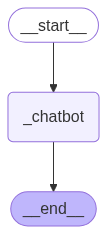

In [30]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

_graph_builder = StateGraph(State)

_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

def _chat_node(_old_state: State) -> State:
    _response = llm.invoke(_old_state.messages)
    _new_message = _old_state.messages + [_response]
    _new_state = State(messages=_new_message)
    return _new_state

_graph_builder.add_node("_chatbot", _chat_node)
_graph_builder.add_edge(START, "_chatbot")
_graph_builder.add_edge("_chatbot", END)

_graph = _graph_builder.compile()

display(Image(_graph.get_graph().draw_mermaid_png()))

In [ ]:
def _chat(user_input: str, history: list):
    messages = history or [{"role": "user", "content": user_input}]
    if history and history[-1]["role"] == "user" and history[-1]["content"] == user_input:
        messages = history
    else:
        messages = history + [{"role": "user", "content": user_input}]

    messages = messages[-4:]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    print("history\n", history)
    return result   ['messages'][-1].content

gr.ChatInterface(_chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7876
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='0be840d7-c594-44cc-8307-eb1d0f52fdca'), AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dee52579-c833-49b2-8cfc-bb8b503a6539-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})]}
history
 []
{'messages': [HumanMessage(content='hi', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='44ef2509-5cb4-4230-bac7-d5c18865d446'), AIMessage(content='Hi there! How can I help you today?', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='252e0102-8906-4575-b9e7-0a17729d7c03'), HumanMessage(content='ohh', additional_kwargs={}, response_metadata={}, id='5e58862e-8ad4-48b6-97a1-f27569

c:\Users\DeepADabhi\Desktop\projects\temp\agents\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1649: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


{'messages': [AIMessage(content='2 + 3 + 5 = 10', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='47640ffc-b985-4a65-b52e-48ee62cf9ae8'), HumanMessage(content='2+3+5', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='ef766075-5b6e-41fc-826b-325ef2e884ff'), AIMessage(content='2 + 3 + 5 = 10', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='03f16360-b42c-4817-b04c-b5a0f0f58f9c'), HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='4bb5cf83-a7ee-4a9a-b31c-baa080195c9d'), AIMessage(content='', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--9fd6ac1d-a693-442e-a1d7-5e8be7c7a76d-0', usage_metadata={'input_tokens': 27, 'output_tokens': 0, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})]}
history
 [{'role': 'user', 'me

c:\Users\DeepADabhi\Desktop\projects\temp\agents\.venv\Lib\site-packages\langchain_google_genai\chat_models.py:1649: UserWarning: HumanMessage with empty content was removed to prevent API error
  warnings.warn(


{'messages': [AIMessage(content='2 + 3 + 5 = 10', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='5f4a1c8b-ca1c-4887-b171-5bad4ac6b591'), HumanMessage(content='', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='167edefa-119d-4ee2-8b70-4f7ab70b4314'), AIMessage(content='', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='0d89521d-8541-4064-8f5e-9e1c3e500f20'), HumanMessage(content='2+3+5\n\n', additional_kwargs={}, response_metadata={}, id='53629489-9530-44b6-a1ea-b344bd8baa61'), AIMessage(content='2 + 3 + 5 = 10', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--95c33993-4059-4fde-bfa2-0678a6d47296-0', usage_metadata={'input_tokens': 17, 'output_tokens': 12, 'total_tokens': 29, 'input_token_details': {'cache_read': 0}})]}
history
 [{'role': 'user'

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].
Traceback (most recent call last):
  File "c:\Users\DeepADabhi\Desktop\projects\temp\agents\.venv\Lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_pr